# HD 155358-GP
This notebook uses a Gaussian Process instead of a Stellar Jitter term for the analysis

In [1]:
import pandas as pd
import numpy as np
import rebound
import emcee
import multiprocessing
import george
from george import kernels

import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("RV.txt", delimiter=' ')

In [3]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RV(times,theta,pp_interaction=1):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    v = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    if pp_interaction == 0:
        sim.testparticle_type = 1 
        sim.N_active = sim.N 
    sim.add(m=m1sini*mJ/sini,a=a1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=a2,l=lambda2,h=h2,k=k2) 
    sim.dt = 2*np.pi* a1**(1.5) / 25.    #dt = 25 steps per orb per of inner planet
    sim.move_to_com()
    for t in times*dtoyr2pi:
        sim.integrate(t)
        v = np.append(v,-AUyr2ms*sim.particles[0].vy*sini)
        #v = np.append(v,AUyr2ms*(sim.particles[0].vx*np.sin(phi) + sim.particles[0].vy*np.cos(phi))*sini) #coordinate transf from (x,y,z)->(x',y',z'), take y' component
    return v 

### GP Chicken Scratch

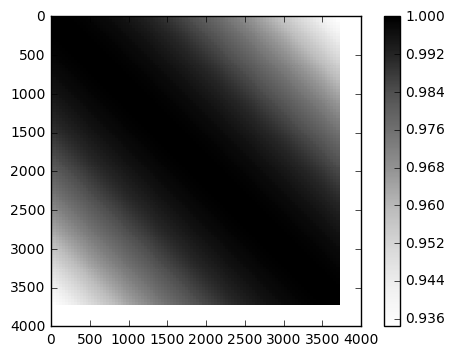

(<matplotlib.colorbar.Colorbar at 0x10ec0e350>, None, None, None)

In [20]:
#chicken scratch plot which shows the covariance matrix as a function of A and L. 
a,l=1,1e8
t = data["BJD"] - data["BJD"].iloc[0]
my_gp = george.GP(a * kernels.ExpSquaredKernel(l) )
my_gp.compute(data["RV"].values, data["Unc"].values)  # matrix needs to know the times and values of the diagonal elements
# Plotting
tm = np.linspace(t.min(),t.max(),1e2) - t.min()
plt.pcolormesh(tm, tm, my_gp.get_matrix(tm), cmap=plt.get_cmap('Greys'))
plt.colorbar(), plt.axes().set_aspect('equal'), plt.gca().invert_yaxis(), plt.show()

### emcee

In [6]:
#arguments
quasiperiodicGP = 0                        #1=semi-periodic GP, 0=purely exponential GP
pp_interaction = 1                         #1=planet-planet interaction, 0=ignore planet-planet interaction

In [7]:
if quasiperiodicGP == 1:                   #exponential * sinusoidal term, following Damasso et al. (2016)
    def lnlikeGP(theta_GP, times, y, yerr, pp_interaction):
        theta, offset = theta_GP[:11], theta_GP[11]
        A, L, G, P = theta_GP[12:] 
        gp = george.GP(A*A * (kernels.ExpSquaredKernel(L) * kernels.ExpSine2Kernel(G, P)))
        gp.compute(times, yerr)
        model = fit_RV(times, theta, pp_interaction) + offset
        return gp.lnlikelihood(y - model)

    def lnpriorGP(theta_GP):
        m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,offset,A,L,G,P = theta_GP
        if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.2<a1<0.8 and 0.8<a2<1.4 and 0<=h1**2 + k1**2<1. and 0<=h2**2 + k2**2<1. and -1<h1<1 and -1<h2<1 and -1<k1<1 and -1<k2<1 and 0.<=lambda1<=2*np.pi and 0.<=lambda2<=2*np.pi and 0.05<=sini<=1. and -40<offset<40 and 0<A<10 and 0<L<6000 and 0<G<100 and 0<P<6000:
            return 0   
        return -np.inf     
elif quasiperiodicGP == 0:                  #exponential only
    def lnlikeGP(theta_GP, times, y, yerr, pp_interaction):
        theta, offset = theta_GP[:11], theta_GP[11]
        A, L = theta_GP[12:]
        gp = george.GP(A*A*kernels.ExpSquaredKernel(L) )
        gp.compute(times, yerr)
        model = fit_RV(times, theta, pp_interaction) + offset
        return gp.lnlikelihood(y - model)

    def lnpriorGP(theta_GP):
        m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,offset,A,L = theta_GP
        if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.2<a1<0.8 and 0.8<a2<1.4 and 0<=h1**2 + k1**2<1. and 0<=h2**2 + k2**2<1. and -1<h1<1 and -1<h2<1 and -1<k1<1 and -1<k2<1 and 0.<=lambda1<=2*np.pi and 0.<=lambda2<=2*np.pi and 0.05<=sini<=1. and -40<offset<40 and 0<A<10 and 0<L<6000:
            return 0   
        return -np.inf 
    
def lnprobGP(theta_j, times, y, yerr, pp_interaction):
    lnp = lnpriorGP(theta_j)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlikeGP(theta_j, times, y, yerr, pp_interaction)

In [8]:
#initialize parameters
times = data["BJD"] - data["BJD"].iloc[0] #BJD (days)
m1sini,m2sini = 0.929,0.841               #Jupiter masses, default 0.85,0.82
a1,a2 = 0.643,1.017                       #AU, default: 0.64, 1.02
h1,h2 = 0.0366,-0.067                     
k1,k2 = -0.167,0.078                      
lambda1,lambda2 = 4.96,1.15               #in radians, default: 129, 233
sini = 0.9                                #inclination angle (0-1)
offset = 4                                #RV offset to account for forward/back motion of star (m/s)
if quasiperiodicGP == 1:
    A, lnL, G, lnP = 1, 1, 0.5, 1         #See Damasso and/or George docs for meanings
    theta_ini = [m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,offset,A,lnL,G,lnP]
elif quasiperiodicGP == 0:
    A, lnL = 1, 1                         #See Damasso and/or George docs for meanings
    theta_ini = [m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,offset,A,lnL]

ndim, nwalkers, n_it, n_checkpoints = len(theta_ini), 300, 10000, 10

Run the MCMC. **Warning**. This could take a while.

In [19]:
filename = "hkGP"
if quasiperiodicGP == 1: #semi-periodic GP (vs. pure exponential)
    filename += "QP"
if pp_interaction == 0: #semi-active bodies 
    filename += "SA"
filename += "_%dwalk_%dit"%(nwalkers,n_it)

p0 = [theta_ini + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobGP, args=(times, data["RV"].values, data["Unc"].values, pp_interaction));

print("Running burn-in...")
pos, _, _ = sampler.run_mcmc(p0, 200)
np.save(filename+"_burnin.npy",sampler.chain)
sampler.reset()

print("Running production...")
for i in range(n_checkpoints):
    pos, _, _ = sampler.run_mcmc(pos, n_it/n_checkpoints);
    np.save(filename+"_chkpt%d.npy"%i,sampler.chain)

Running burn-in...
Running production...


# Load and analyze data

In [9]:
#Corner plot
burnin = 1000

#filename="emcee_chains/hkGP_120walk_2400it_chkpt3"
#filename="emcee_chains/hkGPSP_300walk_10000it_chkpt9"
filename="emcee_chains/hkGP_300walk_10000it_chkpt9"

samples = np.load(filename+".npy")[:, burnin:, :].reshape((-1, ndim))

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


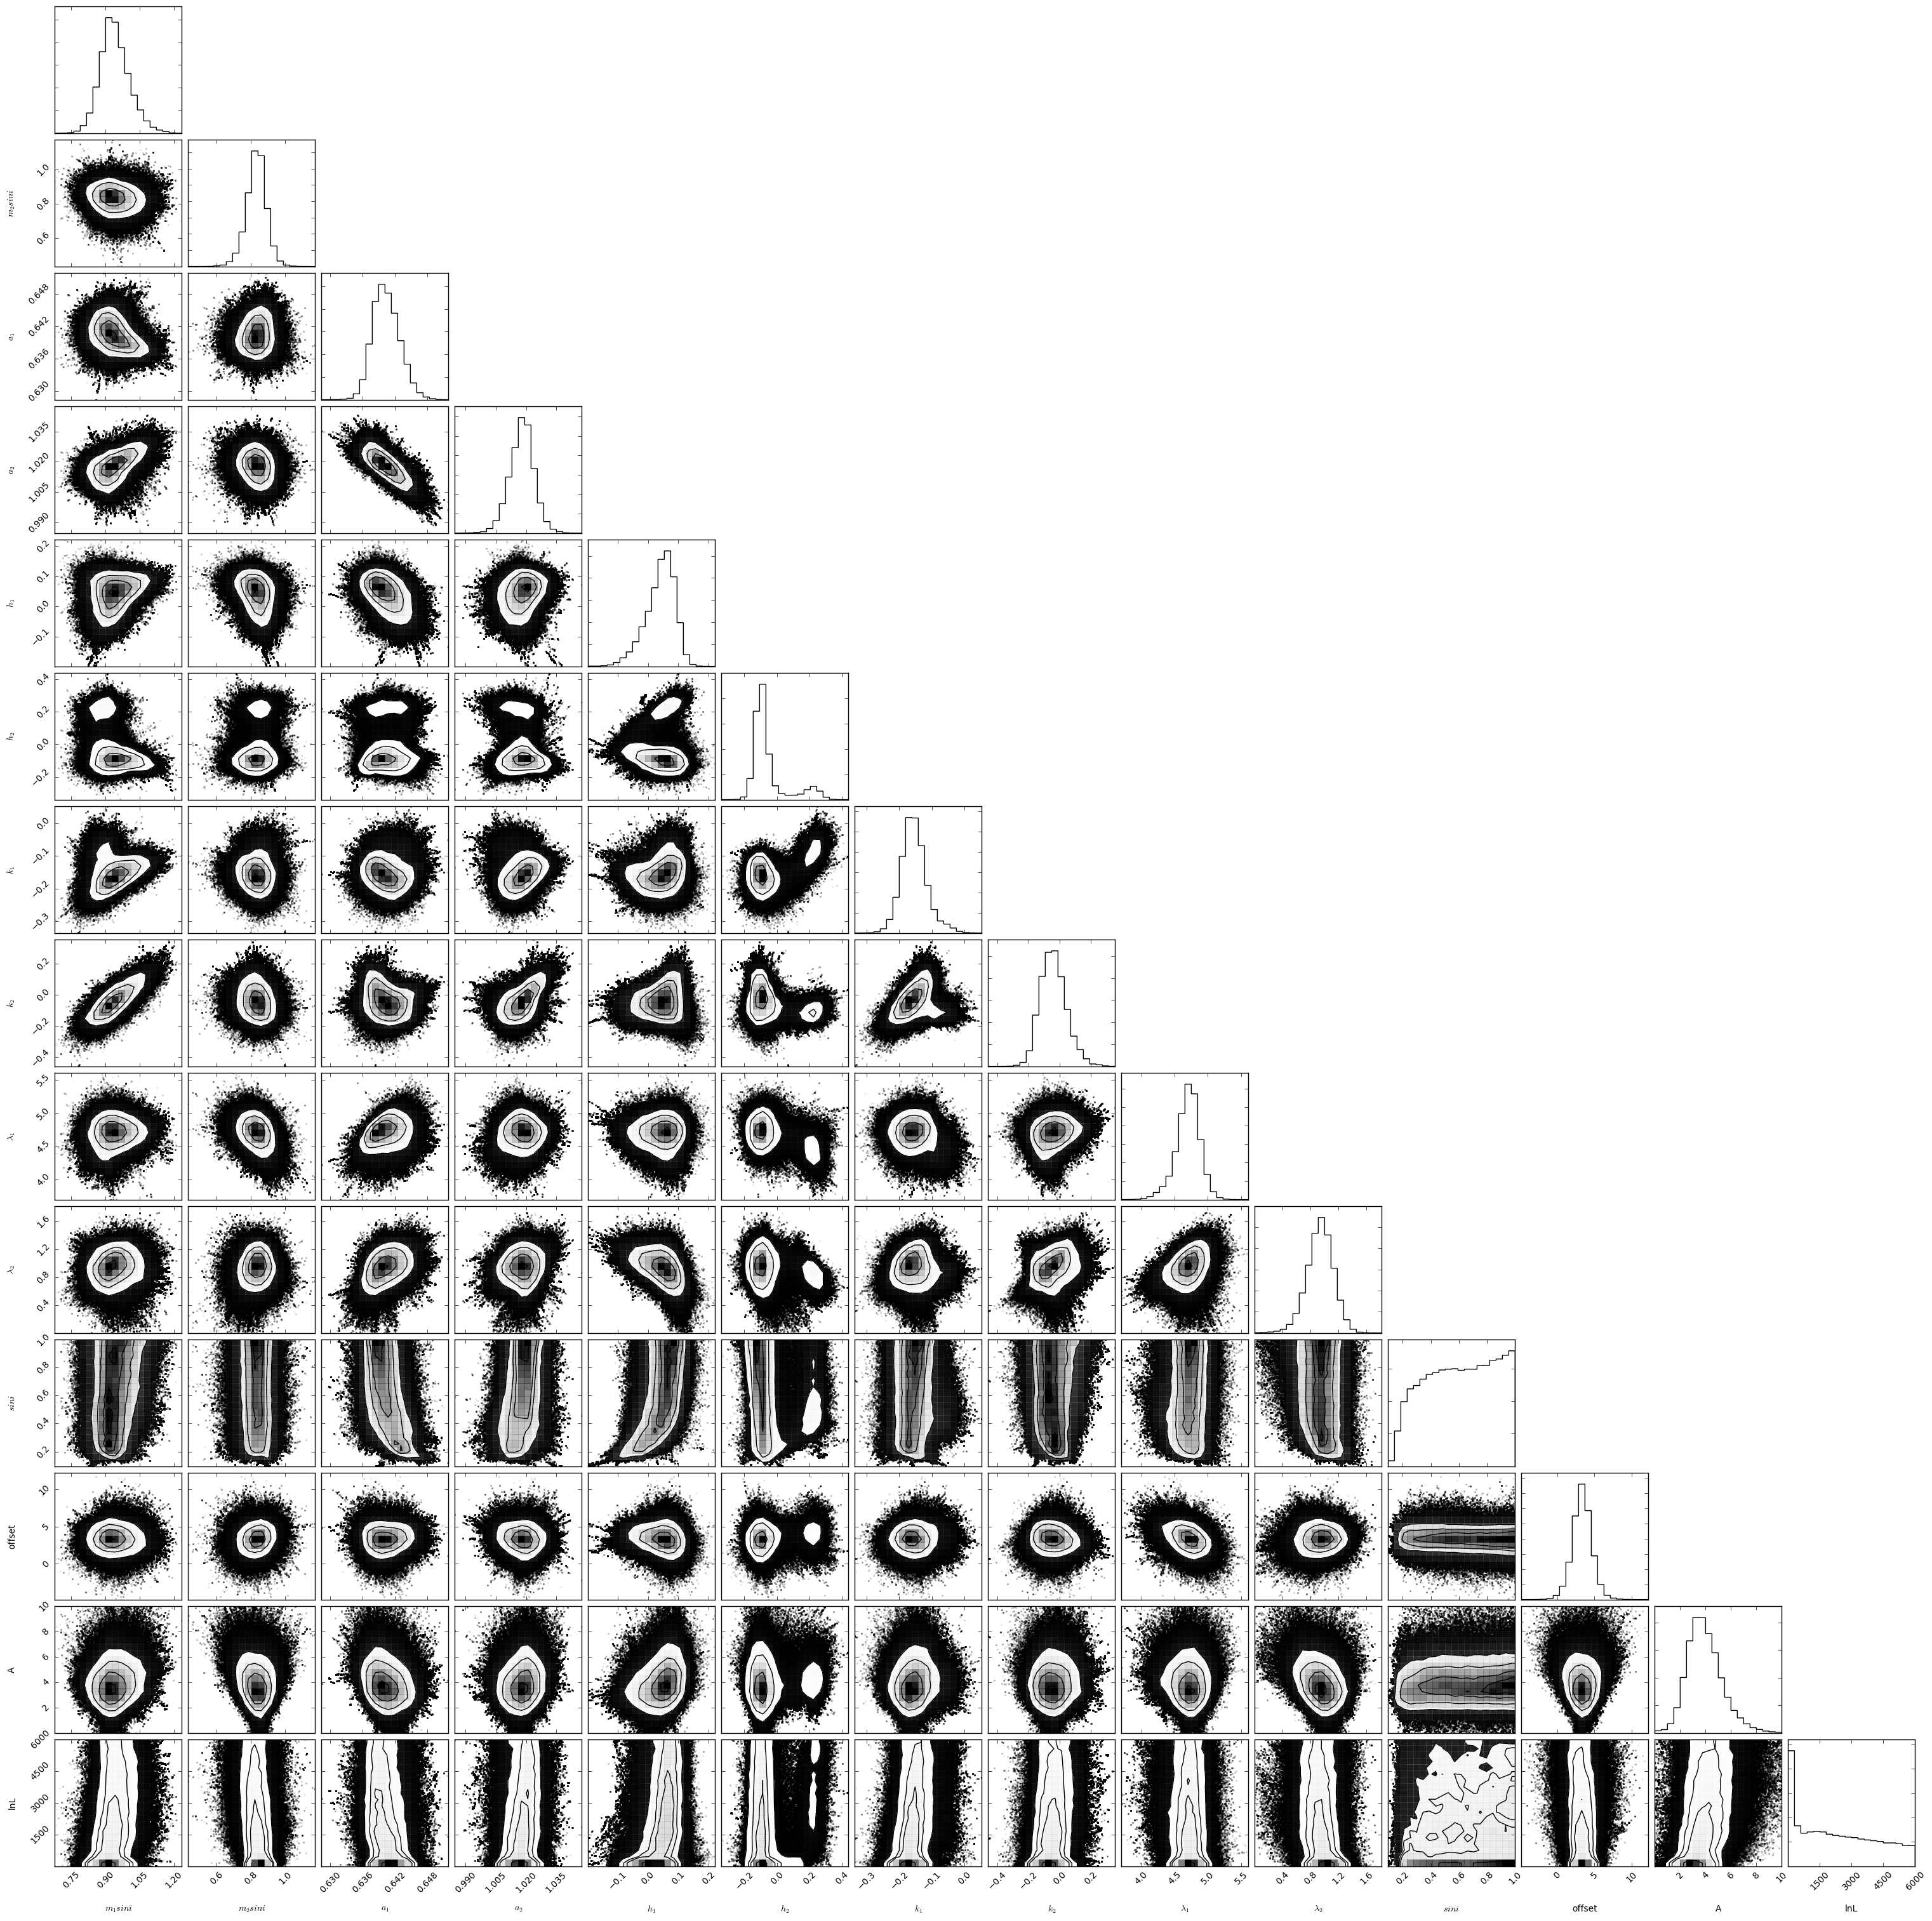

In [10]:
labels = ["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$h_1$","$h_2$","$k_1$","$k_2$","$\lambda_1$","$\lambda_2$","$sini$","offset","A","L"]
if quasiperiodicGP == 1:
    labels = ["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$h_1$","$h_2$","$k_1$","$k_2$","$\lambda_1$","$\lambda_2$","$sini$","offset","A","L","G","lnP"]

fig = corner.corner(samples, labels=labels)
fig.savefig(filename+"_corner.png")

### Get/Plot MAP

In [ ]:
#Better way to do this? This result could depend on the binning. 
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambd1","lambd2","sini","offset","A","L"]
MAP = []
MAP_ = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print "parameter \t MAP \t\t upper \t\t lower"
for i in range(ndim):
    print "%s \t\t %.5f \t %.5f \t %.5f"%(labels[i],MAP_[i][0],MAP_[i][1],MAP_[i][2])
    MAP.append(MAP_[i][0])

In [ ]:
#plotting stuff
from matplotlib import gridspec
fontsize=13
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])]
plt.subplots_adjust(hspace = 0.25)
axes[0].set_ylabel("RV (m/s)",fontsize=fontsize)
axes[0].set_xlabel("BJD - 2450000",fontsize=fontsize)
axes[1].set_ylabel("MAP Residuals (m/s)",fontsize=fontsize)
axes[1].set_xlabel("BJD - 2450000",fontsize=fontsize)
axes[2].set_ylabel("counts",fontsize=fontsize)
axes[2].set_xlabel("Histogram: MAP Residuals (m/s)",fontsize=fontsize)

#samples from posterior
t0 = data["BJD"].iloc[0]
tt = np.linspace(t0,max(data["BJD"]),300)
for theta in samples[np.random.randint(len(samples), size=100)]:
    sampleRV = fit_RV(tt-t0,theta[:11],pp_interaction) + theta[11]
    axes[0].plot(tt,sampleRV,color="k", alpha=0.1)
axes[0].plot(tt,sampleRV,color="k", label='posterior samples')

#MAP
RV = fit_RV(tt-t0,MAP[:11]) + theta[11]
Residuals = data["RV"] - (fit_RV(data["BJD"] - data["BJD"].iloc[0],MAP[:11]) + theta[11])
axes[0].plot(tt,RV, color='green',linewidth=3, label='MAP')
axes[0].errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o', color='blue', label='data')
axes[1].plot(data["BJD"],Residuals, 'o', color='green')
axes[2].hist(Residuals, 18, facecolor='green', alpha=0.75);

#save
axes[0].legend(loc="upper left",fontsize=9,numpoints=1)
plt.savefig(filename+"_MAP_RV.png")

In [ ]:
parameter = 5
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambda1","lambda2","sini","offset","A","L"]
plt.plot(samples[:,parameter], '.', alpha=0.05, color='black')
plt.ylabel(labels[parameter])
plt.xlabel("samples")

## Determine if system is in resonance.

In [ ]:
def res_arg(sim):
    o1 = sim.particles[1].calculate_orbit(sim.particles[0])
    o2 = sim.particles[2].calculate_orbit(sim.particles[0])
    phi = 2.*o2.l - o1.l - o1.pomega
    phi2 = 2.*o2.l - o1.l - o2.pomega
    phi3 = o1.pomega - o2.pomega
    while(phi >= 2*np.pi):
        phi -= 2*np.pi
    while(phi < 0.):
        phi += 2*np.pi
    while(phi2 >= 2*np.pi):
        phi2 -= 2*np.pi
    while(phi2 < 0.):
        phi2 += 2*np.pi
    while(phi3 >= 2*np.pi):
        phi3 -= 2*np.pi
    while(phi3 < 0.):
        phi3 += 2*np.pi
    return phi, phi2, phi3

def check_resonance(theta,tmax,Npts):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    phi, phi2, phi3 = [], [], []
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* a1**(1.5) / 25.    #dt = 50 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,a=a1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=a2,l=lambda2,h=h2,k=k2)  
    sim.move_to_com()
    for t in np.linspace(0,tmax,Npts):
        sim.integrate(t)
        p1,p2,p3 = res_arg(sim)
        phi.append(p1), phi2.append(p2), phi3.append(p3)
    return phi, phi2, phi3

In [ ]:
from matplotlib import gridspec
fontsize=13

#draw samples and see if system is in resonance
tmax = 1000
Npts = 500
Ndraws = 20
phi = []
phi2 = []
phi3 = []
for theta in samples[np.random.randint(len(samples), size=Ndraws)]:
    p1, p2, p3 = check_resonance(theta[:-1],tmax,Npts)
    phi = phi + p1
    phi2 = phi2 + p2
    phi3 = phi3 + p3

#plot
bins = 50
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])]
plt.subplots_adjust(hspace = 0.5)
axes[0].hist(phi, bins, normed=1, facecolor='green', alpha=0.75);
axes[1].hist(phi2, bins, normed=1, facecolor='green', alpha=0.75);
axes[2].hist(phi3, bins, normed=1, facecolor='green', alpha=0.75);
axes[0].set_xlabel(r'$\phi_1 = 2\lambda_2 - \lambda_1 - \overline{\omega}_2$')
axes[1].set_xlabel(r'$\phi_2 = 2\lambda_2 - \lambda_1 - \overline{\omega}_1$')
axes[2].set_xlabel(r'$\phi_3 = \overline{\omega}_2 - \overline{\omega}_1$')
axes[0].set_title('Summed counts from %d systems, each simulated for %d years'%(Ndraws,tmax))
axes[0].set_ylabel('counts')
axes[1].set_ylabel('counts')
axes[2].set_ylabel('counts')
axes[0].set_xlim([0,2*np.pi])
axes[1].set_xlim([0,2*np.pi])
axes[2].set_xlim([0,2*np.pi])
plt.savefig(filename+'_rescheck.png')